#                              Deep Learning - Final Project

###                                  *Trinidad Bosch*

###      The Simpsons                         
___________


### Step 1: Dataset Analysis and manipulation
- drop null values
- look data and make decisions in terms of filtering

This dataset contains the lines of the 27 first seasons of 'The Simpsons'. It contains 2 columns: character and spoken words.

In [1]:
import pandas as pd #for data handling
import re #for preprocessing
import time #to check time of operations
import matplotlib.pyplot as mp #for visualization

In [2]:
#Import dataset 
df = pd.read_csv (r'simpsons_dataset.csv')
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [3]:
#Renaming columns for better use
df.rename(columns = {'raw_character_text':'character', 'spoken_words':'text'}, inplace = True)
df.head()

,character,text
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [4]:
#Check if there are null in the data set
df.isnull().sum()

character    17814
text         26459
dtype: int64

In [5]:
#Dropping null values before text preprocessing
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

character    0
text         0
dtype: int64

In [7]:
#df.head()

>Before doing any preprocessing we wanted to have a look on the most important characters of the serie, therefore decided to  filter the dataset and work with those characters that have more than 500 dialogue lines. 

In [6]:
#Check the % count of the dialogues of each character
df.character.value_counts(normalize=True)*100
df.character.value_counts()
#len(df['text'])

Homer Simpson                  27850
Marge Simpson                  13172
Bart Simpson                   12995
Lisa Simpson                   10756
C. Montgomery Burns             3077
Moe Szyslak                     2808
Seymour Skinner                 2385
Ned Flanders                    2056
Grampa Simpson                  1802
Chief Wiggum                    1790
Milhouse Van Houten             1750
Krusty the Clown                1699
Lenny Leonard                   1144
Nelson Muntz                    1143
Apu Nahasapeemapetilon           988
Waylon Smithers                  960
Kent Brockman                    880
Carl Carlson                     852
Edna Krabappel-Flanders          719
Dr. Julius Hibbert               671
Selma Bouvier                    566
Barney Gumble                    558
Rev. Timothy Lovejoy             550
Sideshow Bob                     527
Gary Chalmers                    516
Groundskeeper Willie             496
Mayor Joe Quimby                 494
R

<AxesSubplot:>

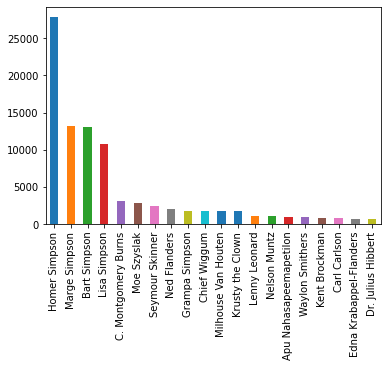

In [7]:
df['character'].value_counts()[:20].plot(kind='bar')

50% of the total lines dialogues corresponds to the Simpson family where Homer 20% of the total. To have a more meaningfull analysis we decided to work with those characters where the count of dialogues is above 1000.

In [8]:
#creating a column that stores the count of each character in the data set 
df['count'] = df.groupby(['character'])['character'].transform('count')

In [9]:
#Filter those characters that have a count of 500 or more
final_df = df.loc[df['count'] >= 1000] 
#final_df

In [10]:
final_df.character.value_counts()
len_ = len(final_df['text'])
len_1 = len(df['text'])
print('-------')
print(f'We will work with {len_} dialogues which corresponds to a {format(((len_/len_1)*100),".2f")} % of the original dataset') 
print('-------')

-------
We will work with 84427 dialogues which corresponds to a 64.03 % of the original dataset
-------


### Step 2: Extracting contextualized Embeddings
> Add description here

In [58]:
pip install -U sentence-transformers

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 85 kB 4.6 MB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 4.0 MB 19.1 MB/s            
     |█████████████████████▉          | 600.2 MB 120.2 MB/s eta 0:00:03

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 881.9 MB 14 kB/s               
     |████████████████████████████████| 23.3 MB 20.1 MB/s            
     |████████████████████████████████| 1.3 MB 57.7 MB/s            
     |████████████████████████████████| 67 kB 8.8 MB/s             
     |████████████████████████████████| 880 kB 56.6 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 6.6 MB 36.4 MB/s            
     |██████████████████████          | 608.1 MB 116.3 MB/s eta 0:00:03

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 881.9 MB 25 kB/s               
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=e1b8df5573a967f12cb7c0d925a093979c2bedbc6db5d483ffaa92fedc7b3002
  Stored in directory: /export/home/trinidad.bosch-achondo/.cache/pip/wheels/c9/90/11/0e58d454669bc8daf94e04a8da9956aa6f78eb10cddb16dd4e
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=1b90de75bfaa86e7c84b6a609ee24bb901b3e30b8ca0e901a9e74ce365fb37e3
  Stored in directory: /export/home/trinidad.bosch-achondo/.cache/pip/wheels/4c/64/31/e9900a234b23fb3e9dc565d6114a9d6ff84a72dbdd356502b4
Successfully built sentence-transformers sacremoses
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this direct

In [11]:
from sklearn import preprocessing
from sklearn.cluster import KMeans ## for later clustering
from sentence_transformers import SentenceTransformer
import torch
from transformers import BertTokenizer, BertModel
import pickle, pathlib, re, os
import numpy as np
import keras
from keras import models
from keras import layers
from keras.models import Sequential

In [12]:
if torch.cuda.is_available(): #check if GPU is available      
    device = torch.device("cuda:1") #set device, we need this later to push our model and the data to the GPU to perform computations
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 3 GPU(s) available.
Device name: Quadro RTX 5000


In [13]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  ).to(device) #push the model into the gpu.

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

Loading BERT tokenizer...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [11]:
## Getting our Embeddings

def emb_func(text): 
    
    #adding the special [CLS] and [SEP] tokens
    marked_text = "[CLS] " + text + " [SEP]" 
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    
    # Mark each of the 22 tokens as belonging to sentence '1'
    segments_ids = [1] * len(tokenized_text)

    # Convert inputs to Pytorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    
    model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True,)
    #model.eval()
    
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        print(outputs.size())
    
        # get metadata: number of dimensions, etc
        _, seq_len, dim = outputs[0].shape
        
        # embeddings
        hidden_states = outputs[2]
        
        final_avg_vector = np.zeros(dim)
        
        for hlayer in hlayers[-4:]:
            final_avg_vector = np.array(hlayer[0][i])
            
    return final_avg_vector/4


In [14]:
def part_2(text): 
    
    #adding the special [CLS] and [SEP] tokens
    marked_text = "[CLS] " + text + " [SEP]" 

    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)

    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    
    model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True,)
    #model.eval()
    
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
    
    hidden_states = outputs[2]
    
    del outputs #free gpu
    
    # `hidden_states` has shape [13 x 1 x 22 x 768]
    token_embeddings = torch.stack(hidden_states, dim=0)

    # Remove dimension 1, the "batches"
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    
    token_embeddings = token_embeddings.permute(1,0,2)
   
    #Extracting CLS embedding
    cls_emb = token_embeddings[0][-4:].mean(dim=0).detach().cpu().numpy()

    
    #GENERATING SENTENCE VECTOR
    # extracting layer 12 of the network
    token_vecs = hidden_states[-1][0]

    # Calculate the average of all 22 token vectors.
    sentence_embedding = torch.mean(token_vecs, dim=0)
    
    print ("Sentence embedding vector of shape:", sentence_embedding.size())

    return sentence_embedding, cls_emb

In [15]:
text_list = final_df.text.values.tolist()
labels_list = final_df.character.values.tolist()
print(text_list[:1000])
print(labels_list[:1000])

["Where's Mr. Bergstrom?", 'That life is worth living.', 'Victory party under the slide!', 'Mr. Bergstrom! Mr. Bergstrom!', 'Do you know where I could find him?', 'The train, how like him... traditional, yet environmentally sound.', 'I see he touched you, too.', 'Hey, thanks for your vote, man.', "I didn't vote. Voting's for geeks.", 'Well, you got that right. Thanks for your vote, girls.', "Well, don't sweat it. Just so long as a couple of people did... right, Milhouse?", 'Uh oh.', 'Lewis?', 'Somebody must have voted.', "What about you, Bart? Didn't you vote?", 'Uh oh.', 'I demand a recount.', 'No.', 'Mr. Bergstrom! Hey, Mr. Bergstrom!', 'Hey, Lisa, indeed.', 'Oh, I mean, were you just going to leave, just like that?', "You can't go! You're the best teacher I'll ever have.", 'Oh, please.', 'But I need you too.', "I, I understand. Mr. Bergstrom, I'm going to miss you.", 'Thank you, Mr. Bergstrom.', "So, I guess this is it? It you don't mind I'll just run alongside the train as it speed

In [ ]:
#getting lists for the average and cls embeddings

avg_embeddings = []
cls_embeddings = []

for text in text_list[:1000]:
    result = part_2(text)
    avg_embeddings.append(result[0])
    cls_embeddings.append(result[1])
    

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence embedding vector of shape: torch.Size([768])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
#avg_embeddings
#len(avg_embeddings)

In [26]:
# #Saving Embeddings
with open('avg_embeddings.pkl', 'wb') as handle:
    pickle.dump(avg_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('cls_embeddings.pkl', 'wb') as handle:
    pickle.dump(cls_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [88]:
#Loading Embeddings
with open('avg_embeddings.pkl', 'rb') as handle:
    avg_embeddings = pickle.load(handle)

with open('cls_embeddings.pkl', 'rb') as handle:
    cls_embeddings = pickle.load(handle)

## Step 3: Multi-class classification

As our aim is to predict the character of a sentence, our task is a Multi-class classification one where we will train a model with labeled data (name of characters.


### Classification with averaged embeddings

In [94]:
type(avg_embeddings)
#avg_embeddings

numpy.ndarray

In [64]:
#arrange indices 
indices = np.arange(np.array(avg_embeddings).shape[0])
np.random.shuffle(indices)

In [89]:
avg_embeddings = [t.detach().numpy() for t in avg_embeddings]
avg_embeddings, labels = np.array(avg_embeddings), np.array(labels_list)

In [92]:
#Leave this line of code because it works
avg_embeddings= np.array(avg_embeddings)

In [93]:
avg_embeddings = avg_embeddings[indices]
labels_list = labels[indices]
labels_list = np.unique(labels_list, return_inverse=True)[1]

In [103]:
#Define train and test set
training_samples = (max(indices) * 80)//100 #dividing 80%


x_train = avg_embeddings[:training_samples]
y_train = labels_list[:training_samples]

x_test = avg_embeddings[training_samples:]
y_test = labels_list[training_samples:]


In [104]:
x_train.shape

(7, 768)

In [105]:
# convert to categorical labels
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### 1. Model - One simple layer

In [ ]:
# Defining the model
model = Sequential()
model.add(layers.Dense(7, activation='relu', input_shape=(768,)))

model.add(layers.Dense(len(set(labels)), activation='softmax'))

model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['acc'])#tried rmsprop, adagrad but adamax seems better
model.summary()
history = model.fit(x_train, y_train,
                            epochs=12,
                            batch_size=2)
                            #validation_split=0.5)
model.save_weights('tbbt.h5')